In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [4]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [5]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

In [6]:
# %%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

In [7]:
adata.X.max()

8.8678228953803

In [8]:
adata.layers["raw_count"] = np.exp(adata.X) - 1

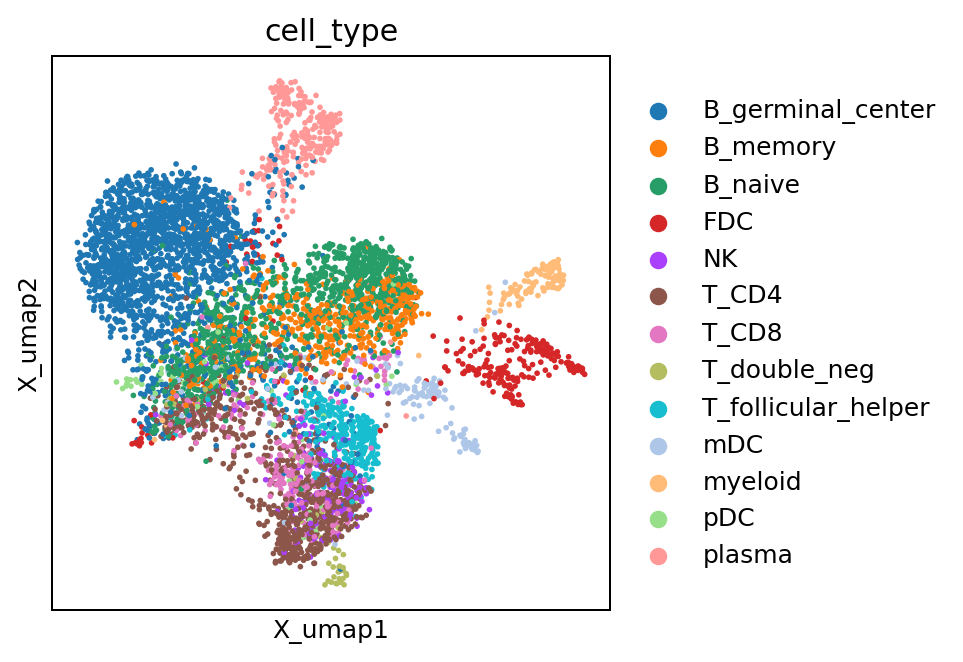

In [9]:
%matplotlib inline

oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [10]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [11]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 13/13 [15:11<00:00, 70.15s/it]

CPU times: user 9min 7s, sys: 25.2 s, total: 9min 32s
Wall time: 15min 12s


In [12]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/13 [00:00<?, ?it/s]

In [13]:
oracle.fit_GRN_for_simulation(
    alpha=1,
    use_cluster_specific_TFdict=True
)

  0%|          | 0/13 [00:00<?, ?it/s]

In [19]:
targets = [
    'PAX5', 'BCL6',  'GATA3', 'PRDM1', 'FOXO1', 'FOXP3', 
]

In [20]:
from tqdm import tqdm

In [21]:
for goi in tqdm(targets):
    oracle.simulate_shift(
        perturb_condition={goi: 0},
        n_propagation=4
    )

    oracle.adata.to_df(layer='simulated_count').to_csv(f'celloracle_{goi}_KO.csv')

100%|██████████| 6/6 [01:48<00:00, 18.11s/it]


In [20]:
import pickle

with open('/Users/koush/Desktop/training_data/snrna_human_tonsil_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [21]:

# links.to_hdf5(file_path="/tmp/links.celloracle.links")
# oracle.to_hdf5("/tmp/tonsil.celloracle.oracle")